# Making geologic cross sections from well logs

In [1]:
# let's import some packages we are going to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import lasio
from textwrap import wrap  # for making pretty well names
from multiprocessing import Pool

%matplotlib inline

### Where did this data come from?
The cell below reads in the LAS file names using glob, and then reads in some fake tops I made up for the cross section. These are close to the top of the Niobrara Formation in the Denver Basin of southeast Wyoming. Well log LAS files are from the [WOGCC](http://pipeline.wyo.gov/legacywogcce.cfm) and tops are eyeballed by me and are probably way off.

In [2]:
wells = []
year = 2016
for name in glob.glob(f"logs/{year}/*.las"):
    wells.append(name)

Now let's create a figure and read in well log. We then plot each log by subsea depth so we can see a structural cross section

In [3]:
def get_depth(well_log):
    try:
        return well_log["DEPT"]
    except:
        return well_log["DEPTH"]

def get_gamma(well_log):
    try:
        return well_log["GR"]
    except:
        try:
            return well_log["GRGC"]
        except:
            try:
                return well_log["GAMMA"]
            except:
                return well_log["GAMMA:1"]

def get_well(well_log):
    try:
        return well_log.well["WELL"]
    except:
        return well_log.well["WELL:1"]

In [ ]:
len(wells)

"GAMMA:1 not found in curves (['DEPTH', 'QUAL', 'CCL', 'GRE', 'CSG1L', 'CSG1R', 'RATI', 'SIGC', 'NEAR', 'FAR', 'DELI', 'AIPN', 'AIPD', 'ARHOB', 'VSH', 'MIN12', 'MIN23', 'MIN34', 'MIN45', 'PHIE', 'SWPN', 'PAYPN', 'BVWPN', 'BVWPNI', 'BVWPNR'])"



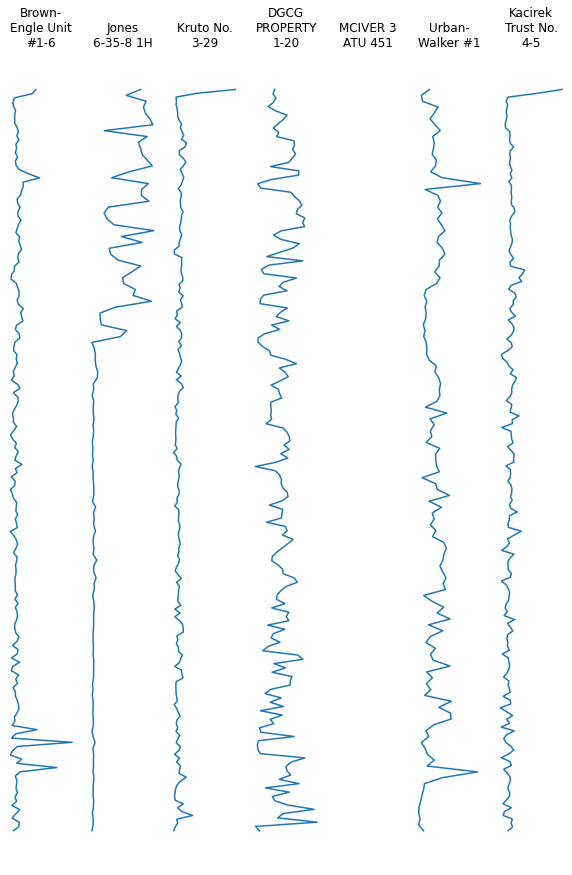

In [22]:
fig = plt.figure(figsize=(10, 15))  # set our figure size

for i, j in enumerate(range(21, 28)):  # we read in the 7 logs
    well_log = lasio.read(wells[j])  # this reads in the log
    ax = fig.add_subplot(
        171 + i
    )  # creates a subplot that the curve will be plotted in
    try:
        ax.plot(
            get_gamma(well_log)[::50],
            get_depth(well_log)[::50],
        )
    except Exception as e:
        print(e)
        print()
        pass
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    # we also downsample the logs so they plot faster
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(get_well(well_log).value, 10)))
    # and let's go ahead and add titles to each log for fun

That's a nice little cross section above, but can we make it better looking? More geologic styling to the gamma-ray curves is possible. Let's investigate this possibility. We will take our plot from above, and we're going to color between the curve and the right hand side. For a full breakdown look at the [coloring well logs notebook](https://github.com/jessepisel/5minutesofpython/blob/master/Well%20log%20plots/gamma%20ray%20colors.ipynb). One last thing we want to do is remove the whitespace between the logs so it looks better and we do that in the last line of the cell

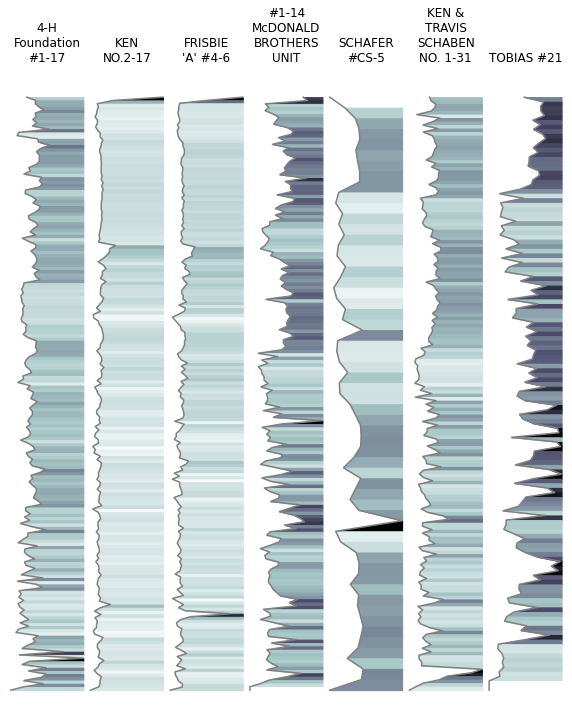

In [23]:
import matplotlib as mpl  # for making a colormap

cmap = mpl.cm.bone_r  # select our color map

fig = plt.figure(figsize=(10, 12))  # set our figure size


for i, j in enumerate(range(14, 21)):  # we read in the 7 logs
    well_log = lasio.read(wells[j])  # this reads in the log
    try:
        x = get_gamma(well_log)[::50]  # assign the GR values to x
        x[np.isnan(x)] = 0
        y = get_depth(well_log)[::50] #% assign the depth values to y
        z = (
             x
        )  # create a third variable for the colors, you could have fun and make this another curve as well
    except Exception as E:
        print(wells[i])
        print(E)
    normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())

    ax = fig.add_subplot(
        171 + i
    )  # creates a subplot that the curve will be plotted in
    ax.plot(x, y, color="gray")
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure

    for k in range(x.size - 1):
        plt.fill_betweenx(
            [y[k], y[k + 1]],
            [x[k], x[k + 1]],
            x2=z.max(),
            color=cmap(normalize(z[k])),
        )
    # let's plot the fake tops from the csv file as a horizontal line, don't forget to subtract the KB elevation for subsea depth
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(well_log.well["WELL"].value, 10)))
    # and let's go ahead and add titles to each log for fun
plt.subplots_adjust(wspace=0, hspace=0)

What else is in the well_log dataframe??

In [24]:
example_log = lasio.read(wells[0])
wells[0]

'logs/2017/1046523532.las'

Lets drop NaN's to see what is concistently there


In [25]:
example_df = example_log.df()
example_df

,LSPD,LTEN,MINMK,TBHV,ABHV,BVTX,AVTX,RWA,RXORT,CILD,...,CNLSC,CNSSC,CNRAT,CNLS,CNSS,CNDL,CNAD,CNPOR,CNPORU,GR
DEPT,,,,,,,,,,,,,,,,,,,,,
2898.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.2985
2898.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.6001
2899.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0665
2899.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.3933
2900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.5976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206.0,4.5,-2218.9426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4206.5,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
well_log.df().dropna()["GR"]

KeyError: 'GR'

In [ ]:
well_log.df()["GR"]

In [ ]:
def plot_well(file_name):
    fig = plt.figure(figsize=(2,10))
    well_log = lasio.read(file_name)  # this reads in the log
    try:
        x = get_gamma(well_log)[::50]  # assign the GR values to x
        x[np.isnan(x)] = 0
        y = get_depth(well_log)[::50] #% assign the depth values to y
        z = (
            x
        )  # create a third variable for the colors, you could have fun and make this another curve as well
    except Exception as E:
        print(file_name)
        print(E)
        plt.close(fig)
        return
    normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())

    plt.plot(x, y, color="gray")
    ax = plt.gca()
    # this does the plotting, we plot gamma ray as a function of depth. note we subtract the kelly bushing elevation (EKB) to get subsea depth
    ax.invert_yaxis()
    # flip the axis so downhole is down in the figure

    for j in range(x.size - 1):
        plt.fill_betweenx(
            [y[j], y[j + 1]],
            [x[j], x[j + 1]],
            x2=z.max(),
            color=cmap(normalize(z[j])),
        ) 
    # let's plot the fake tops from the csv file as a horizontal line, don't forget to subtract the KB elevation for subsea depth
    ax.axis("off")
    # this gets rid of the axis so they look clean
    ax.set_title("\n".join(wrap(f'{get_well(well_log).value}', width=10)))
    # and let's go ahead and add titles to each log for fun
    well_name = get_well(well_log).value
    if type(well_name) == type([]):
        well_name = "".join(well_name)
    else:
        well_name = str(well_name)
    plt.savefig("well_figs/" + well_name.replace('/', '') + ".png", transparent=True)
    plt.close(fig)

In [ ]:
for i, well in enumerate(wells):
    plot_well(well)

In [ ]:
def get_county(well_log):
    if "CNTY" in well_log.well:
        return well_log.well["CNTY"]
    if "CNTY." in well_log.well:
        return well_log.well["CNTY."]
    return f"NA"

sub_wells = wells[0:5]
sub_wells

In [ ]:
# Some of these Errored out when reading, we can skip over those for now and look at how many errors we have
well_logs = []
errors = 0

def add_log(file):
    global errors, well_logs
    try:
        well_logs.append(lasio.read(file))
    except Exception as e:
        print(f"{e} Error number: {errors} on file {file}")
        errors += 1

pool = Pool()
pool.map(add_log, wells);

Cannot reshape ~A data size (161837,) into 39 columns Error number: 0 on file logs/2016/1046089038.las
Cannot reshape ~A data size (48557,) into 39 columns Error number: 0 on file logs/2016/1045662653.las
Cannot reshape ~A data size (59513,) into 39 columns Error number: 0 on file logs/2016/1045662711.las
Cannot reshape ~A data size (25097,) into 4 columns Error number: 0 on file logs/2016/1046102494.las


/home/fastfist/.local/share/virtualenvs/transformers-kgQS_UHh/lib/python3.9/site-packages/lasio/las.py:284: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arr[arr == provisional_null] = np.nan


Cannot reshape ~A data size (691972,) into -1 columns Error number: 0 on file logs/2016/1046114346.las


In [ ]:
errors

In [ ]:
counties = []
for well_log in well_logs:
    counties.append(get_county(well_log))

In [165]:
len(counties)

2278

In [166]:
for i, county in enumerate(counties):
    if type(county) != type(""):
        counties[i] = county.value
    
    counties[i] = counties[i].upper()

In [167]:
kwargs = dict(County=counties)

final_df = pd.DataFrame(kwargs)

In [168]:
final_df

,County
0,SCOTT
1,SCOTT
2,KEARNY
3,DICKINSON
4,ALLEN
...,...
2273,LOGAN
2274,RUSSELL
2275,CHEYENNE
2276,RUSSELL


We found a bunch of typos...

In [185]:
corrections = {
    "ELI WIRELINE": "NA",
    "LGAN": "LOGAN",
    "SALINA": "SALINE",
    "HARPER CO": "HARPER",
    "HARPER CO.": "HARPER",
    "SUMMER": "SUMNER",
    "SEDOWICK": "SEDGWICK",
    "ELLS": "ELLIS",
    "NESS CO.": "NESS",
    '': "NA",
    "HODGMAN": "HODGEMAN",
    "USA" : "NA",
    "KANSAS" : "NA",
    "RUSSEL" : "RUSSELL",
    "PRATT COUNTY" : "PRATT",
    "WITCHITA" : "WICHITA",
    "RUCH" : "RUSH",
    "RAWLINGS" : "RAWLINS",
}
for key, value in corrections.items():
    final_df.loc[final_df["County"] == key] = value

In [186]:
freq_count = final_df["County"].value_counts()
freq_df = pd.DataFrame({"County": freq_count.keys(), "Frequency": freq_count.values})
freq_df = freq_df.sort_values(by="Frequency", ascending=False)
freq_df = freq_df.reset_index(drop=True)
freq_df

,County,Frequency
0,NA,121
1,ELLIS,110
2,LOGAN,106
3,SCOTT,99
4,RAWLINS,98
...,...,...
67,SEDGWICK,1
68,COMANCHE,1
69,ELK,1
70,JACKSON,1


In [187]:
freq_df["Percent"] = freq_df['Frequency'] /freq_df["Frequency"].sum() * 100
freq_df

,County,Frequency,Percent
0,NA,121,5.311677
1,ELLIS,110,4.828797
2,LOGAN,106,4.653205
3,SCOTT,99,4.345917
4,RAWLINS,98,4.302019
...,...,...,...
67,SEDGWICK,1,0.043898
68,COMANCHE,1,0.043898
69,ELK,1,0.043898
70,JACKSON,1,0.043898


<BarContainer object of 72 artists>

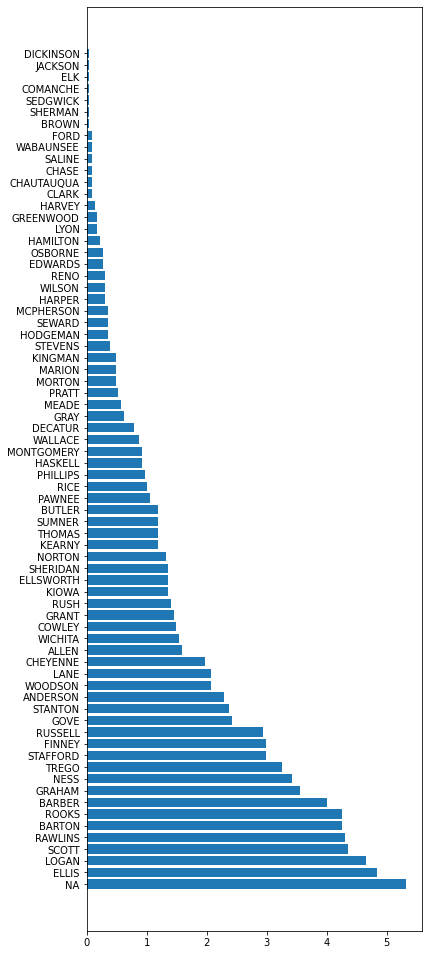

In [188]:
fig = plt.figure(figsize=(6,17))
plt.yticks(range(len(freq_df)), freq_df["County"])
plt.barh(range(len(freq_df)), freq_df["Percent"])

In [189]:
freq_df[freq_df["County"] == "NA"]

,County,Frequency,Percent
0,NA,121,5.311677


In [190]:
freq_df.head(10)

,County,Frequency,Percent
0,NA,121,5.311677
1,ELLIS,110,4.828797
2,LOGAN,106,4.653205
3,SCOTT,99,4.345917
4,RAWLINS,98,4.302019
5,BARTON,97,4.258121
6,ROOKS,97,4.258121
7,BARBER,91,3.994732
8,GRAHAM,81,3.555751
9,NESS,78,3.424056


<AxesSubplot:>

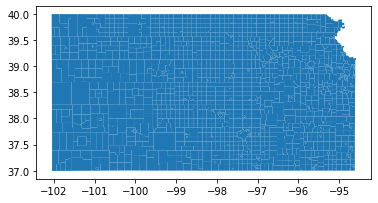

In [191]:
import geopandas as gpd
kansas_map = gpd.read_file("kansas.zip")
kansas_map.plot()

We want to find the county codes for each

In [192]:
fpis = pd.read_csv("fips.csv")
fpis

,fips,name,state
0,0,UNITED STATES,NaN
1,1000,ALABAMA,NaN
2,1001,Autauga County,AL
3,1003,Baldwin County,AL
4,1005,Barbour County,AL
...,...,...,...
3190,56037,Sweetwater County,WY
3191,56039,Teton County,WY
3192,56041,Uinta County,WY
3193,56043,Washakie County,WY


In [193]:
freq_df

,County,Frequency,Percent
0,NA,121,5.311677
1,ELLIS,110,4.828797
2,LOGAN,106,4.653205
3,SCOTT,99,4.345917
4,RAWLINS,98,4.302019
...,...,...,...
67,SEDGWICK,1,0.043898
68,COMANCHE,1,0.043898
69,ELK,1,0.043898
70,JACKSON,1,0.043898


In [194]:
freq_df["COUNTYFP"] = 0

In [195]:
freq_df[freq_df["County"] == "KANSAS"]

,County,Frequency,Percent,COUNTYFP


In [196]:
for index, county in freq_df["County"].iteritems():
    name = county.capitalize() + " County"
    if name == "Mcpherson County":
        name = "McPherson County"
    q1 = fpis[fpis["name"] == name]
    try:
        freq_df.loc[index, "COUNTYFP"] = str(q1[q1["state"] == "KS"]["fips"].iloc[0])[2:]
    except Exception as e:
        print("None - " + county)

None - NA


Now we can join the two together

<AxesSubplot:>

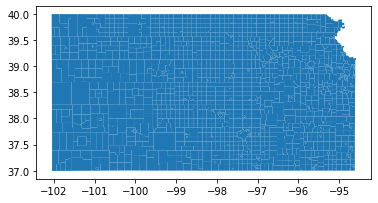

In [197]:
kansas_map.plot()

In [198]:
freq_df[freq_df["County"] == "NA"]

,County,Frequency,Percent,COUNTYFP
0,NA,121,5.311677,0


<AxesSubplot:>

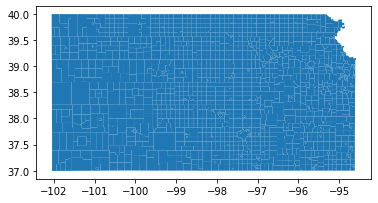

In [199]:
density_map = kansas_map
density_map = density_map.merge(freq_df, on = "COUNTYFP", how = "left")
density_map.plot()

In [200]:
density_map.Frequency.unique()

array([ nan,   8.,  27.,  30.,  34.,  97.,  52., 106.,  55.,  81.,  13.,
        68.,   2.,  22.,  78.,   3.,  18.,  74.,  21.,  47.,   4.,  11.,
         5.,   1.,  36.,  35.,   7.,  23.,  99.,  98.,  24.,  45.,  32.,
        33.,  31.,  12.,   6.,  91.,  20.,  14.,   9.,  54., 110.,  67.])

In [201]:
density_map = density_map.fillna(0)

In [202]:
density_map["Frequency"].unique()

array([  0.,   8.,  27.,  30.,  34.,  97.,  52., 106.,  55.,  81.,  13.,
        68.,   2.,  22.,  78.,   3.,  18.,  74.,  21.,  47.,   4.,  11.,
         5.,   1.,  36.,  35.,   7.,  23.,  99.,  98.,  24.,  45.,  32.,
        33.,  31.,  12.,   6.,  91.,  20.,  14.,   9.,  54., 110.,  67.])

density_map.plot(column="Frequency", cmap = 'inferno', legend=True)
plt.title(f"Kansas Well County Distribution - {year}")
plt.savefig(f"kansas_map {year}.png")

In [204]:
kansas_map["COUNTYFP"]

0       139
1       139
2       139
3       139
4       113
       ... 
1526    167
1527    167
1528    147
1529    147
1530    147
Name: COUNTYFP, Length: 1531, dtype: object

In [205]:
freq_df["COUNTYFP"].unique()

array([0, '051', '109', '171', '153', '009', '163', '007', '065', '135',
       '195', '185', '055', '167', '063', '187', '003', '207', '101',
       '023', '001', '203', '035', '067', '165', '097', '053', '179',
       '137', '093', '193', '191', '015', '145', '159', '147', '081',
       '125', '199', '039', '069', '119', '151', '129', '115', '095',
       '189', '083', '175', '113', '077', '205', '155', '047', '141',
       '075', '111', '073', '079', '025', '019', '017', '169', '197',
       '057', '013', '181', '173', '033', '049', '085', '041'],
      dtype=object)